# Import basic modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tqdm import tqdm

# Loading Dataset

In [2]:
train_loc = 'data\Train'
val_loc = 'data\Valid'
test_loc = 'data\Test'

BATCH_SIZE = 16

trdata = ImageDataGenerator()
train_ds = trdata.flow_from_directory(directory=train_loc, target_size=(224,224),batch_size=BATCH_SIZE, shuffle=True,
                                               seed=42)

vdata = ImageDataGenerator()
val_ds = vdata.flow_from_directory(directory=val_loc, target_size=(224,224),batch_size=BATCH_SIZE, shuffle=True,
                                               seed=42)

tsdata = ImageDataGenerator()
test_ds = tsdata.flow_from_directory(directory=test_loc, target_size=(224,224),batch_size=BATCH_SIZE, shuffle=False, seed = 42)

Found 41503 files belonging to 6 classes.
Using 33203 files for training.


2022-08-09 19:02:25.735967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 19:02:25.865336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 19:02:25.866090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 19:02:25.872027: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 41503 files belonging to 6 classes.
Using 8300 files for validation.
Found 3192 files belonging to 2 classes.


In [3]:
# There are 6 classes for training dataset
class_names = train_ds.class_names
class_names

['chickenpox', 'cowpox', 'healthy', 'measles', 'monkeypox', 'smallpox']

2022-08-09 19:02:41.532764: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


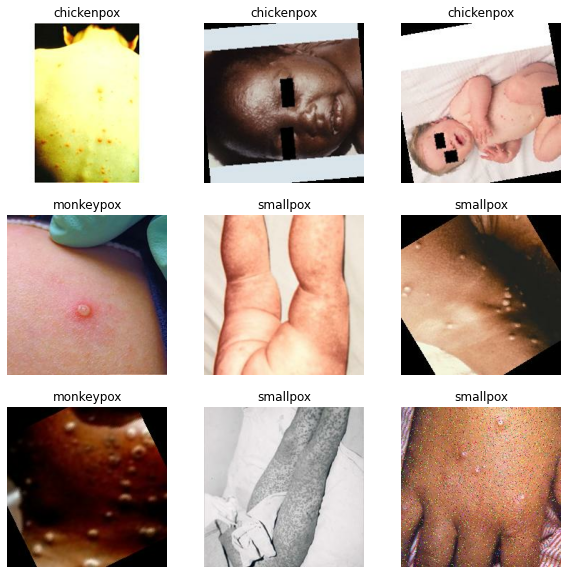

In [4]:
# Lets take a peak what's inside
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

# Training model

In [5]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

# Define model
model = Sequential()

# Download ResNet50
pretrained_model= ResNet50(include_top=False,
                           input_shape=(224, 224, 3), # Input shape dimension
                           pooling='avg', # AvgPool
                           classes=6, # Total output
                           weights='imagenet')

# Disable train on ResNet50
for layer in pretrained_model.layers:
    layer.trainable=False

# ResNet50 Layers
model.add(pretrained_model)
# Flatten all data
model.add(Flatten())
# Fully connected layers with 512 neurons
model.add(Dense(512, activation='relu'))
# Output layers
model.add(Dense(6, activation='softmax'))

# Give summary
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 24,639,878
Trainable params: 1,052,166
Non-trainable params: 23,587,712
_________________________________________________________________


In [6]:
# Compile model. If you want to optimize this, you can tuning learning rate and etc but its just too slowwwwwww
model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Finally train this neural net. Ten epochs seems ok to me
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


2022-08-09 19:02:50.971761: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1038/1038 [==============================] - 131s 117ms/step - loss: 0.3994 - accuracy: 0.8552 - val_loss: 0.1998 - val_accuracy: 0.9269
Epoch 2/10
1038/1038 [==============================] - 80s 77ms/step - loss: 0.1250 - accuracy: 0.9552 - val_loss: 0.1365 - val_accuracy: 0.9545
Epoch 3/10
1038/1038 [==============================] - 79s 76ms/step - loss: 0.0778 - accuracy: 0.9719 - val_loss: 0.1201 - val_accuracy: 0.9600
Epoch 4/10
1038/1038 [==============================] - 80s 76ms/step - loss: 0.0540 - accuracy: 0.9812 - val_loss: 0.1142 - val_accuracy: 0.9634
Epoch 5/10
1038/1038 [==============================] - 80s 77ms/step - loss: 0.0484 - accuracy: 0.9833 - val_loss: 0.1021 - val_accuracy: 0.9687
Epoch 6/10
1038/1038 [==============================] - 80s 77ms/step - loss: 0.0383 - accuracy: 0.9868 - val_loss: 0.0911 - val_accuracy: 0.9711
Epoch 7/10
1038/1038 [==============================] - 79s 76ms/step - loss: 0.0290 - accuracy: 0.9897 - val_loss: 0.0878 - val_accu

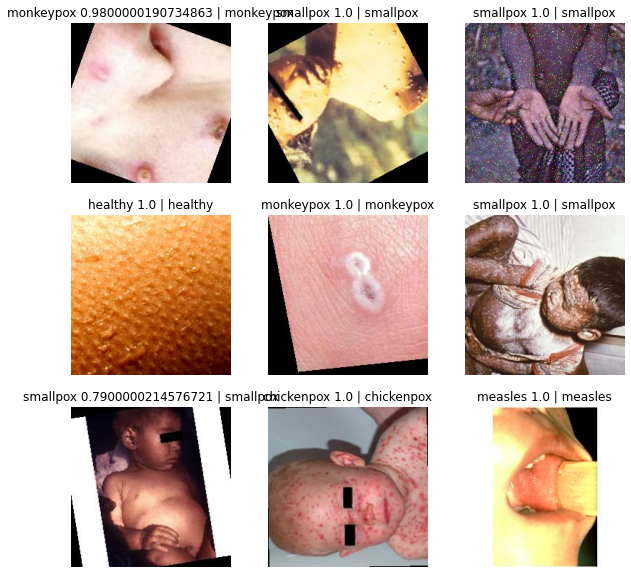

In [7]:
# Just random testing
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        result = model(np.expand_dims(images[i], axis=0))
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{class_names[np.argmax(result)]} {round(np.max(result), 2)} | {class_names[np.argmax(labels[i])]}")
        plt.axis("off")

# Validation
I like to manually validate my model and calculate everything with sklearn package

In [8]:
# Predict everything inside validation dataset
labels = []
predictions = []

for X, y in tqdm(val_ds):
    for i in range(len(X)):
        result = model(np.expand_dims(X[i], axis=0))

        predictions.append(class_names[np.argmax(result)])
        labels.append(class_names[np.argmax(y[i])])

100%|██████████| 260/260 [07:15<00:00,  1.68s/it]


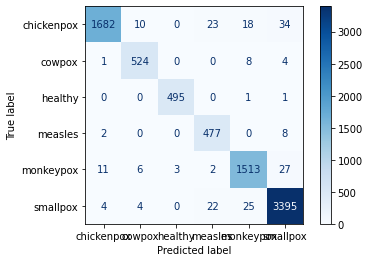

In [9]:
# Show confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(labels, predictions, cmap='Blues')
plt.show()

In [10]:
# Calculate some ML metrics on average
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy score : ', accuracy_score(labels, predictions))
print('Precision score : ', precision_score(labels, predictions, average='weighted'))
print('Recall score : ', recall_score(labels, predictions, average='weighted'))
print('F1 score : ', f1_score(labels, predictions, average='weighted'))

Accuracy score :  0.9742168674698796
Precision score :  0.9746238135176312
Recall score :  0.9742168674698796
F1 score :  0.9742629775788092


In [11]:
# Take a look more detail on each label. Maybe something unbalance
from sklearn.metrics import classification_report

print(classification_report(labels, predictions))

              precision    recall  f1-score   support

  chickenpox       0.99      0.95      0.97      1767
      cowpox       0.96      0.98      0.97       537
     healthy       0.99      1.00      0.99       497
     measles       0.91      0.98      0.94       487
   monkeypox       0.97      0.97      0.97      1562
    smallpox       0.98      0.98      0.98      3450

    accuracy                           0.97      8300
   macro avg       0.97      0.98      0.97      8300
weighted avg       0.97      0.97      0.97      8300



# Testing
Test on another dataset

In [12]:
test_ds.class_names

['Monkeypox_augmented', 'Others_augmented']

In [13]:
labels = []
predictions = []

for X, y in tqdm(test_ds):
    for i in range(len(X)):
        result = model(np.expand_dims(X[i], axis=0))

        predictions.append(class_names[np.argmax(result)] == "monkeypox")
        labels.append(test_ds.class_names[np.argmax(y[i])] == "Monkeypox_augmented")

100%|██████████| 100/100 [02:49<00:00,  1.70s/it]


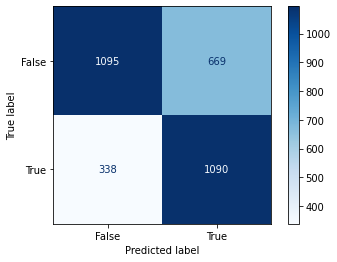

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(labels, predictions, cmap='Blues')
plt.show()

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy score : ', accuracy_score(labels, predictions))
print('Precision score : ', precision_score(labels, predictions, average='weighted'))
print('Recall score : ', recall_score(labels, predictions, average='weighted'))
print('F1 score : ', f1_score(labels, predictions, average='weighted'))

Accuracy score :  0.6845238095238095
Precision score :  0.6995039368860456
Recall score :  0.6845238095238095
F1 score :  0.6845750531537499


In [16]:
from sklearn.metrics import classification_report

print(classification_report(labels, predictions))

              precision    recall  f1-score   support

       False       0.76      0.62      0.69      1764
        True       0.62      0.76      0.68      1428

    accuracy                           0.68      3192
   macro avg       0.69      0.69      0.68      3192
weighted avg       0.70      0.68      0.68      3192



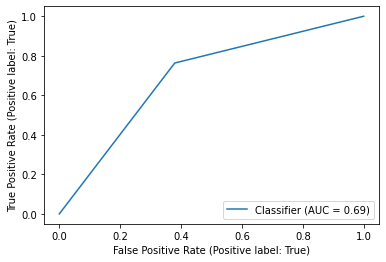

In [17]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(labels, predictions, pos_label=True)
plt.show()

# Export model (optional)

In [18]:
model.save('saved_model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [19]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('saved_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 24,639,878
Trainable params: 1,052,166
Non-trainable params: 23,587,712
_________________________________________________________________
